# Attempts on Success Prediction from VW Post Content

There are two approaches we can do to try to predict success: regression and classification.

## 1. Regression
X = similarity of a post with the dimensions

y = success score

We will try two models: Linear Regression and a Fully-Connected Neural Network

## 2. Classification

### 2.1 Simple Models
X = similarity of a post with the dimensions

y = 0/1 (1 if post is successful, i.e. success > 208, the mean of the data after removing top 10% and bottom 10%)

We will try logistic regression and FCNN.

### 2.2 More Complicated Models
We will try two LSTM architectures in this part. We cut each post to the first 50 tokens.

**LSTM1** : Use the embedding vectors of each the words as input to the LSTM, then pass into a sequence of fully connected layers.

**LSTM2** : Use embedding vectors as input to the LSTM, concatenate dimension similarity vector with the output of the LSTM, then pass the concatenated vector into a sequence of fully connected layers.

In [1]:
import operator, re, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from neurotools.io.files import load_embedding_model
from neurotools.io.gdrive import download_sheets_doc
from neurotools.plot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from neurotools.language.simple_tokenizer import SimpleTokenizer
from wordcloud import WordCloud
from googletrans import Translator
import itertools
import ast
from neurotools.io.gdrive import download_sheets_doc
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, concatenate
from keras.callbacks import EarlyStopping

In [4]:
sns.set_style("white")

In [5]:
import matplotlib as mpl
mpl.rc('font',family='Open Sans')

# Load tokenizer, embedding, etc.

In [6]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


In [7]:
emb, word2rank_dict = load_embedding_model('../../vw-impact/utils/pl_pl_commoncrawl_v3.bin')

In [8]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys() and word not in ['bezpieczeństwo', 'pistolet']]
    return np.mean(words_in_emb, axis=0)

In [9]:
def get_idf_map(documents):
    tfidf = TfidfVectorizer(use_idf=True)
    tfidf.fit_transform(documents)
    word_to_idf = dict((x[0], tfidf.idf_[x[1]]) for x in sorted(tfidf.vocabulary_.items(), key=operator.itemgetter(1)))
    return word_to_idf

In [10]:
def get_idf_weighted_average_vector(words, word_to_idf, emb):
    """
        Average the idf-weighted word vectors of a list of words. (Map this function to every document)
    """
    # only consider words IN embedding model and in TFIDF vectorizer
    words = [word for word in words if word in word_to_idf.keys() and word in emb.vocab.keys() and word not in ['bezpieczeństwo', 'pistolet']]
    weighted = [word_to_idf[word] * emb[word] for word in words]
    return np.mean(weighted, axis=0)

In [11]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [12]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['dimension'].shape[0]):
        name = str(dimensions['en_label'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['dimension'].iloc[k])
    return row

# 1. Regression using Lin Regression and MLP

In [290]:
vw = pd.read_csv('../processed/processed_volkswagenpolska.csv')

In [331]:
vw = vw[['Trendy',
       'Kind', 'Polite', 'Warm', 'Diligent', 'Blue_Collar', 'White_Collar',
       'Protective', 'Serious', 'Funny', 'Pleasant', 'Beautiful', 'Alive',
       'Above', 'Descriptive', 'Cheap', 'Expensive', 'Big', 'Small', 'Modern',
       'Traditional', 'Appealing', 'Sustainable', 'Practical', 'Active',
       'Easy', 'Trustworthy', 'Natural', 'Arts', 'Career', 'Family', 'Female',
       'Male', 'Math', 'Science', 'Open', 'Cool', 'Likeable', 'Children',
       'Community', 'Culture', 'Design', 'Innovative', 'Responsible',
       'Extroverted', 'Fascination', 'Friendship', 'Functionality', 'Winner',
       'Lifestyle', 'Music', 'New', 'Bargain', 'Power', 'Safety', 'Teaching',
       'Technical', 'Valuable', 'Feel Good', 'Support', 'Inspire', 'Happiness',
       'Celebrate', 'Meaningful', 'success']]

In [332]:
vw = vw[~vw['Trendy'].isnull()]

In [333]:
y = vw['success']

In [334]:
retain = (y[~pd.qcut(y, 10, labels=range(10)).isin([0,9])]).index

In [335]:
X = vw.loc[retain,:].iloc[:,:-1]
y = vw.loc[retain,:].iloc[:,-1]
# logy = np.log(y)

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 1.1 Linear Regression

In [338]:
lr = LinearRegression()

In [339]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [340]:
lr.score(X_train, y_train)

0.11279695387314803

In [341]:
lr.score(X_test, y_test)

0.034201241371870195

(-64.0, 1344.0, -401.3974343887023, 258.1500786533325)

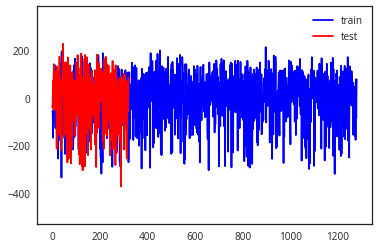

In [342]:
plt.plot(lr.predict(X_train).reshape(-1)- y_train.values, color='blue', label='train')
plt.plot(lr.predict(X_test).reshape(-1)-y_test.values, color='red', label='test')
plt.legend()
plt.axis('equal')

In [343]:
print(y_train.mean())
print(y_test.mean())

206.30366900858704
211.8785046728972


High residuals. Model did not generalize to the test set!

## 1.2 Neural Network

In [344]:
model = Sequential()
model.add(Dense(32, input_shape = (X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [345]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 9         
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


In [346]:
model.fit(X_train, y_train, epochs=250, batch_size=64)

Epoch 1/250
1281/1281 [==============================] - 2s 2ms/step - loss: 54290.7075
Epoch 2/250
1281/1281 [==============================] - 0s 41us/step - loss: 53226.7251
Epoch 3/250
1281/1281 [==============================] - 0s 40us/step - loss: 51753.9687
Epoch 4/250
1281/1281 [==============================] - 0s 39us/step - loss: 49464.9914
Epoch 5/250
1281/1281 [==============================] - 0s 48us/step - loss: 46283.5251
Epoch 6/250
1281/1281 [==============================] - 0s 46us/step - loss: 42214.1269
Epoch 7/250
1281/1281 [==============================] - 0s 49us/step - loss: 37286.6825
Epoch 8/250
1281/1281 [==============================] - 0s 39us/step - loss: 32346.7834
Epoch 9/250
1281/1281 [==============================] - 0s 42us/step - loss: 27516.2589
Epoch 10/250
1281/1281 [==============================] - 0s 36us/step - loss: 25497.9089
Epoch 11/250
1281/1281 [==============================] - 0s 43us/step - loss: 24449.0477
Epoch 12/250
1281/12

1281/1281 [==============================] - 0s 30us/step - loss: 19340.0539
Epoch 93/250
1281/1281 [==============================] - 0s 31us/step - loss: 19649.6727
Epoch 94/250
1281/1281 [==============================] - 0s 33us/step - loss: 19383.9873
Epoch 95/250
1281/1281 [==============================] - 0s 32us/step - loss: 20030.3908
Epoch 96/250
1281/1281 [==============================] - 0s 33us/step - loss: 19274.4172
Epoch 97/250
1281/1281 [==============================] - 0s 32us/step - loss: 19577.0429
Epoch 98/250
1281/1281 [==============================] - 0s 32us/step - loss: 18702.4709
Epoch 99/250
1281/1281 [==============================] - 0s 31us/step - loss: 20280.1399
Epoch 100/250
1281/1281 [==============================] - 0s 37us/step - loss: 19190.6920
Epoch 101/250
1281/1281 [==============================] - 0s 36us/step - loss: 20491.8865
Epoch 102/250
1281/1281 [==============================] - 0s 34us/step - loss: 19657.7556
Epoch 103/250
1281/1

1281/1281 [==============================] - 0s 48us/step - loss: 17552.5402
Epoch 183/250
1281/1281 [==============================] - 0s 106us/step - loss: 18028.9280
Epoch 184/250
1281/1281 [==============================] - 0s 85us/step - loss: 17669.2352
Epoch 185/250
1281/1281 [==============================] - 0s 67us/step - loss: 19493.2120
Epoch 186/250
1281/1281 [==============================] - 0s 58us/step - loss: 18351.4604
Epoch 187/250
1281/1281 [==============================] - 0s 40us/step - loss: 18646.0878
Epoch 188/250
1281/1281 [==============================] - 0s 41us/step - loss: 18740.6167
Epoch 189/250
1281/1281 [==============================] - 0s 55us/step - loss: 17984.1045
Epoch 190/250
1281/1281 [==============================] - 0s 47us/step - loss: 18363.4666
Epoch 191/250
1281/1281 [==============================] - 0s 36us/step - loss: 17819.8527
Epoch 192/250
1281/1281 [==============================] - 0s 33us/step - loss: 18042.7760
Epoch 193/25

In [348]:
model.evaluate(X_train, y_train)

1281/1281 [==============================] - 0s 51us/step


13022.089966773243

In [349]:
model.evaluate(X_test, y_test)

321/321 [==============================] - 0s 46us/step


13692.947099822333

(-64.0, 1344.0, -391.2797401428223, 173.53744583129884)

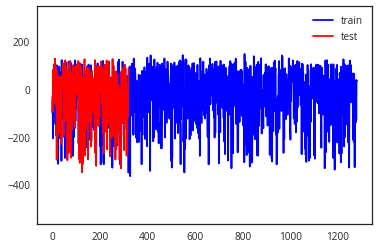

In [350]:
plt.plot(model.predict(X_train).reshape(-1)- y_train.values, color='blue', label='train')
plt.plot(model.predict(X_test).reshape(-1)-y_test.values, color='red', label='test')
plt.legend()
plt.axis('equal')

Still high residuals. Model did not generalize to the test set.

# 2.1 Classification with Log Res and MLP

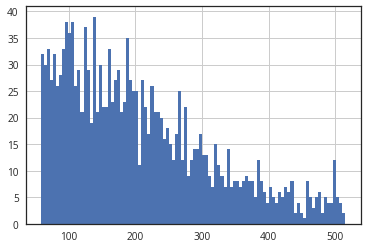

In [352]:
y.hist(bins=100)

In [353]:
cy = (y>=208).astype(int)

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, cy, test_size=0.20, random_state=42)

## 2.1.1 Logistic Regression

In [355]:
log = LogisticRegressionCV(class_weight='balanced')

In [356]:
log.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [357]:
log.score(X_train, y_train)

0.6370023419203747

In [358]:
log.score(X_test, y_test)

0.5825545171339563

In [359]:
y_train.value_counts()

0    744
1    537
Name: success, dtype: int64

In [361]:
744/(537+744)

0.5807962529274004

Model just about does the same as random guessing.

## 2.1.2 Neural Network

In [399]:
model = Sequential()
model.add(Dense(8, input_shape = (X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=10)

In [400]:
model.fit(X_train, y_train, epochs=250, batch_size=64, class_weight=y_train, validation_data=(X_test, y_test), callbacks=[es])

Train on 1281 samples, validate on 321 samples
Epoch 1/250
1281/1281 [==============================] - 2s 2ms/step - loss: 4.3893 - acc: 0.3903 - val_loss: 4.8476 - val_acc: 0.5670
Epoch 2/250
1281/1281 [==============================] - 0s 47us/step - loss: 4.0462 - acc: 0.4590 - val_loss: 1.2368 - val_acc: 0.5670
Epoch 3/250
1281/1281 [==============================] - 0s 60us/step - loss: 3.8911 - acc: 0.4582 - val_loss: 0.8018 - val_acc: 0.5452
Epoch 4/250
1281/1281 [==============================] - 0s 57us/step - loss: 3.9419 - acc: 0.4645 - val_loss: 0.8174 - val_acc: 0.5607
Epoch 5/250
1281/1281 [==============================] - 0s 62us/step - loss: 3.5177 - acc: 0.4738 - val_loss: 1.0529 - val_acc: 0.5670
Epoch 6/250
1281/1281 [==============================] - 0s 59us/step - loss: 3.2788 - acc: 0.4988 - val_loss: 1.0089 - val_acc: 0.5670
Epoch 7/250
1281/1281 [==============================] - 0s 60us/step - loss: 3.1593 - acc: 0.5113 - val_loss: 0.8919 - val_acc: 0.5670
Ep

1281/1281 [==============================] - 0s 77us/step - loss: 1.1429 - acc: 0.5215 - val_loss: 0.6870 - val_acc: 0.5607
Epoch 61/250
1281/1281 [==============================] - 0s 70us/step - loss: 1.1240 - acc: 0.5191 - val_loss: 0.6874 - val_acc: 0.5639
Epoch 62/250
1281/1281 [==============================] - 0s 69us/step - loss: 1.0181 - acc: 0.5363 - val_loss: 0.6862 - val_acc: 0.5576
Epoch 63/250
1281/1281 [==============================] - 0s 68us/step - loss: 1.0458 - acc: 0.5137 - val_loss: 0.6865 - val_acc: 0.5639
Epoch 64/250
1281/1281 [==============================] - 0s 76us/step - loss: 0.8542 - acc: 0.5402 - val_loss: 0.6905 - val_acc: 0.5670
Epoch 65/250
1281/1281 [==============================] - 0s 60us/step - loss: 0.8279 - acc: 0.5652 - val_loss: 0.6907 - val_acc: 0.5670
Epoch 66/250
1281/1281 [==============================] - 0s 62us/step - loss: 0.8082 - acc: 0.5582 - val_loss: 0.6919 - val_acc: 0.5670
Epoch 67/250
1281/1281 [==============================

In [401]:
model.evaluate(X_train, y_train)

1281/1281 [==============================] - 0s 49us/step


[0.6893631466937009, 0.5807962529274004]

In [402]:
model.evaluate(X_test, y_test)

321/321 [==============================] - 0s 56us/step


[0.6926563574331943, 0.5669781931464174]

In [403]:
print(confusion_matrix(y_test, model.predict_classes(X_test).reshape(-1)))
print(classification_report(y_test, model.predict_classes(X_test).reshape(-1)))

[[182   0]
 [139   0]]
             precision    recall  f1-score   support

          0       0.57      1.00      0.72       182
          1       0.00      0.00      0.00       139

avg / total       0.32      0.57      0.41       321



/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Classification with LSTM models

## 1. embedding vector -> LSTM -> success


In [404]:
vw = pd.read_csv('../processed/processed_volkswagenpolska.csv')

In [405]:
vw = vw[['tokens', 'Trendy',
       'Kind', 'Polite', 'Warm', 'Diligent', 'Blue_Collar', 'White_Collar',
       'Protective', 'Serious', 'Funny', 'Pleasant', 'Beautiful', 'Alive',
       'Above', 'Descriptive', 'Cheap', 'Expensive', 'Big', 'Small', 'Modern',
       'Traditional', 'Appealing', 'Sustainable', 'Practical', 'Active',
       'Easy', 'Trustworthy', 'Natural', 'Arts', 'Career', 'Family', 'Female',
       'Male', 'Math', 'Science', 'Open', 'Cool', 'Likeable', 'Children',
       'Community', 'Culture', 'Design', 'Innovative', 'Responsible',
       'Extroverted', 'Fascination', 'Friendship', 'Functionality', 'Winner',
       'Lifestyle', 'Music', 'New', 'Bargain', 'Power', 'Safety', 'Teaching',
       'Technical', 'Valuable', 'Feel Good', 'Support', 'Inspire', 'Happiness',
       'Celebrate', 'Meaningful', 'success']]

In [406]:
y = vw['success']

In [407]:
# retain = (y[pd.qcut(y, 10, labels=range(10)).isin([0])]).index

In [408]:
# vw = vw.loc[retain,:]

In [409]:
vw['tokens'] = vw['tokens'].map(ast.literal_eval)

In [410]:
vw = vw[~vw['Trendy'].isnull()]

In [411]:
vw['sequence'] = vw['tokens'].map(lambda words: [get_average_vector([x], emb) for x in words if x in emb.vocab.keys() and x not in ['bezpieczeństwo', 'pistolet']])

In [412]:
def clip(seq):
    x = None
    if len(seq) >= 50:
        x = seq[:50]
        return x
    else:
        x = seq.copy()
        x.extend(np.zeros((50 - len(seq),300), dtype=np.float32))
        return x

In [413]:
vw['clipped'] = vw['sequence'].map(clip)

In [414]:
vw['success'].mean()

276.9885229540918

In [415]:
vw['class'] = (vw['success']>=208).astype(int)

In [416]:
vw['class'].value_counts()

0    1127
1     877
Name: class, dtype: int64

In [417]:
X = vw[['clipped', 'Trendy',
       'Kind', 'Polite', 'Warm', 'Diligent', 'Blue_Collar', 'White_Collar',
       'Protective', 'Serious', 'Funny', 'Pleasant', 'Beautiful', 'Alive',
       'Above', 'Descriptive', 'Cheap', 'Expensive', 'Big', 'Small', 'Modern',
       'Traditional', 'Appealing', 'Sustainable', 'Practical', 'Active',
       'Easy', 'Trustworthy', 'Natural', 'Arts', 'Career', 'Family', 'Female',
       'Male', 'Math', 'Science', 'Open', 'Cool', 'Likeable', 'Children',
       'Community', 'Culture', 'Design', 'Innovative', 'Responsible',
       'Extroverted', 'Fascination', 'Friendship', 'Functionality', 'Winner',
       'Lifestyle', 'Music', 'New', 'Bargain', 'Power', 'Safety', 'Teaching',
       'Technical', 'Valuable', 'Feel Good', 'Support', 'Inspire', 'Happiness',
       'Celebrate', 'Meaningful']]
y = vw['class']

In [418]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.40, random_state=42, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.50, random_state=42, stratify = y_valtest)

In [419]:
wv_train = []
for i in range(len(X_train)):
    wv_train.append(np.array(X_train['clipped'].values[i]))
wv_train = np.array(wv_train)

wv_val = []
for i in range(len(X_val)):
    wv_val.append(np.array(X_val['clipped'].values[i]))
wv_val = np.array(wv_val)

wv_test = []
for i in range(len(X_test)):
    wv_test.append(np.array(X_test['clipped'].values[i]))
wv_test = np.array(wv_test)

In [420]:
model1 = Sequential()
model1.add(LSTM(16, input_shape=(wv_train.shape[1],wv_train.shape[2],)))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=10)

In [421]:
model1.fit(wv_train, y_train, epochs=50, batch_size=64, class_weight=y_train, validation_data=(wv_val, y_val), callbacks=[es])

Train on 1202 samples, validate on 401 samples
Epoch 1/50
1202/1202 [==============================] - 5s 4ms/step - loss: 0.6967 - acc: 0.5341 - val_loss: 0.6912 - val_acc: 0.5561
Epoch 2/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6902 - acc: 0.5574 - val_loss: 0.6878 - val_acc: 0.5636
Epoch 3/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6875 - acc: 0.5666 - val_loss: 0.6863 - val_acc: 0.5636
Epoch 4/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6896 - acc: 0.5649 - val_loss: 0.6860 - val_acc: 0.5611
Epoch 5/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6863 - acc: 0.5666 - val_loss: 0.6860 - val_acc: 0.5611
Epoch 6/50
1202/1202 [==============================] - 2s 1ms/step - loss: 0.6828 - acc: 0.5691 - val_loss: 0.6855 - val_acc: 0.5636
Epoch 7/50
1202/1202 [==============================] - 2s 1ms/step - loss: 0.6780 - acc: 0.5641 - val_loss: 0.6847 - val_acc: 0.5636
Epoch 8/50
1202

In [422]:
model1.evaluate(wv_train, y_train)

1202/1202 [==============================] - 1s 596us/step


[0.41702984831297457, 0.801996671915451]

In [423]:
print(confusion_matrix(y_train, model1.predict_classes(wv_train).reshape(-1)))
print(classification_report(y_train, model1.predict_classes(wv_train).reshape(-1)))

[[452 224]
 [ 14 512]]
             precision    recall  f1-score   support

          0       0.97      0.67      0.79       676
          1       0.70      0.97      0.81       526

avg / total       0.85      0.80      0.80      1202



In [424]:
model1.evaluate(wv_val, y_val)

401/401 [==============================] - 0s 554us/step


[0.8095539288033273, 0.5935162095506292]

In [425]:
print(confusion_matrix(y_val, model1.predict_classes(wv_val).reshape(-1)))
print(classification_report(y_val, model1.predict_classes(wv_val).reshape(-1)))

[[108 117]
 [ 46 130]]
             precision    recall  f1-score   support

          0       0.70      0.48      0.57       225
          1       0.53      0.74      0.61       176

avg / total       0.62      0.59      0.59       401



In [426]:
model1.evaluate(wv_test, y_test)

401/401 [==============================] - 0s 452us/step


[0.8316488358148019, 0.571072319945195]

In [442]:
model1.save('lstm1')

## 2. (embedding vector -> LSTM) + (dimension similarity) -> success

In [427]:
sim_train = X_train.iloc[:,1:]
sim_val = X_val.iloc[:,1:]
sim_test = X_test.iloc[:,1:]

In [428]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

In [429]:
main_input = Input(shape=(wv_train.shape[1], wv_train.shape[2],), dtype='float32', name='main_input')

In [430]:
lstm = LSTM(16)(main_input)

In [431]:
auxiliary_input = Input(shape=(sim_train.shape[1], ), name='aux_input')

In [432]:
x = concatenate([lstm, auxiliary_input])

In [433]:
drop1 = Dropout(0.5)(x)
dense1 = Dense(8, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense1)
main_output = Dense(1, activation='sigmoid', name='main_output')(drop2)
es = EarlyStopping(monitor='val_loss', patience=10)

In [434]:
model2 = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

In [435]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [436]:
model2.fit([wv_train, sim_train], y_train,
          epochs=50, batch_size=64, class_weight=y_train, validation_data = (
              {'main_input': wv_val, 'aux_input': sim_val}, {'main_output': y_val}
          ), callbacks=[es])

Train on 1202 samples, validate on 401 samples
Epoch 1/50
1202/1202 [==============================] - 4s 4ms/step - loss: 0.6998 - acc: 0.5075 - val_loss: 0.6901 - val_acc: 0.5486
Epoch 2/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6908 - acc: 0.5491 - val_loss: 0.6878 - val_acc: 0.5611
Epoch 3/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6931 - acc: 0.5474 - val_loss: 0.6875 - val_acc: 0.5586
Epoch 4/50
1202/1202 [==============================] - 2s 1ms/step - loss: 0.6886 - acc: 0.5599 - val_loss: 0.6866 - val_acc: 0.5561
Epoch 5/50
1202/1202 [==============================] - 2s 1ms/step - loss: 0.6864 - acc: 0.5632 - val_loss: 0.6851 - val_acc: 0.5586
Epoch 6/50
1202/1202 [==============================] - 2s 1ms/step - loss: 0.6857 - acc: 0.5557 - val_loss: 0.6849 - val_acc: 0.5636
Epoch 7/50
1202/1202 [==============================] - 1s 1ms/step - loss: 0.6891 - acc: 0.5632 - val_loss: 0.6851 - val_acc: 0.5636
Epoch 8/50
1202

In [437]:
model2.evaluate([wv_train, sim_train], y_train)

1202/1202 [==============================] - 1s 574us/step


[0.3595322126060873, 0.8594009984352823]

In [438]:
model2.evaluate([wv_val, sim_val], y_val)

401/401 [==============================] - 0s 550us/step


[0.8584535784852177, 0.5985037407226991]

In [454]:
print(confusion_matrix(y_val, (model2.predict([wv_val, sim_val]).reshape(-1)>.5).astype(int)))
print(classification_report(y_val, (model2.predict([wv_val, sim_val]).reshape(-1)>.5).astype(int)))

[[115 110]
 [ 51 125]]
             precision    recall  f1-score   support

          0       0.69      0.51      0.59       225
          1       0.53      0.71      0.61       176

avg / total       0.62      0.60      0.60       401



In [439]:
model2.evaluate([wv_test, sim_test], y_test)s

401/401 [==============================] - 0s 511us/step


[0.8790594981495579, 0.6134663349077886]

In [455]:
print(confusion_matrix(y_test, (model2.predict([wv_val, sim_test]).reshape(-1)>.5).astype(int)))
print(classification_report(y_test, (model2.predict([wv_val, sim_test]).reshape(-1)>.5).astype(int)))

[[ 96 130]
 [ 70 105]]
             precision    recall  f1-score   support

          0       0.58      0.42      0.49       226
          1       0.45      0.60      0.51       175

avg / total       0.52      0.50      0.50       401



In [456]:
model2.save('lstm2')